In [1]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [2]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:


100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


Loading names:


100%|██████████| 6/6 [00:00<?, ?it/s]


## Initial Centroiding

#### TOF Parameters


In [4]:
"""
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="TOF",
                                                                                                signal_to_noise=2.0, spacing_difference=1.5,
                                                                                                peak_width=0.0, sn_bin_count=100, nr_iterations=5, sn_win_len=20.0,
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))
"""

'\nfia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="TOF",\n                                                                                                signal_to_noise=2.0, spacing_difference=1.5,\n                                                                                                peak_width=0.0, sn_bin_count=100, nr_iterations=5, sn_win_len=20.0,\n                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",\n                                                                                                deepcopy=False))\n'

## Data pruning & binning

In [5]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["bin_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Summing intensities

In [6]:
fia_df["sum_spectra"] = fia_df["bin_experiment"].apply(lambda experiment: sum_spectra(experiment)) # type: ignore

## Combining

In [7]:
comb_df = pd.DataFrame(columns=["polarity", "comb_experiment"])
for polarity in fia_df["polarity"].unique():
    comb_df.loc[len(comb_df.index)] = [polarity, combine_spectra_experiments(fia_df.loc[fia_df["polarity"] == polarity]["sum_spectra"].to_list())]

## Clustering

In [8]:
comb_df["clustered_experiment"] = comb_df["comb_experiment"].apply(lambda experiment: cluster_sliding_window(experiment, window_len=2000, window_shift=1000, threshold=0.07**2))

100%|██████████| 1998/1998 [00:15<00:00, 132.37it/s]


## Merging

In [30]:
all_merged_df = merge_mz_tolerance(comb_df, charge=1, tolerance=1e-3)

100%|██████████| 77403/77403 [07:32<00:00, 171.20it/s]


## Plotting

#### Clustered

c:\Users\JosuaCarl\Desktop\Thesis\MStoML\skripts\FIA\FIA.py:1448: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette)  # type: ignore


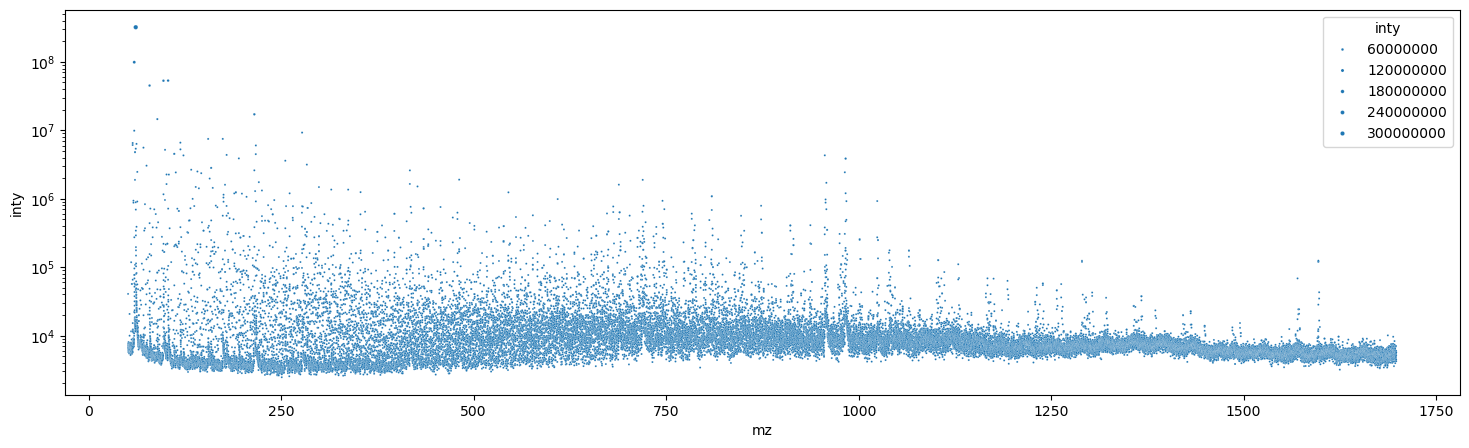

In [96]:
clustered_df = comb_df["clustered_experiment"][0].get_df(long=True)
sns_plot(clustered_df["mz"], clustered_df["inty"], xlim=None, ylim=None, plottype="scatter",
         size=clustered_df["inty"], log=["y"], sizes=(2, 10), palette="hls")   # distinct: tab10, continous: hls

In [104]:
all_merged_df["mz"]

0          51.017555
1          51.024410
2          51.053551
3          51.062302
4          51.109295
            ...     
74792    1698.069092
74793    1698.081909
74794    1698.111694
74795    1698.146606
74796    1698.157959
Name: mz, Length: 74797, dtype: float32

#### Merged

c:\Users\JosuaCarl\Desktop\Thesis\MStoML\skripts\FIA\FIA.py:1448: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette)  # type: ignore


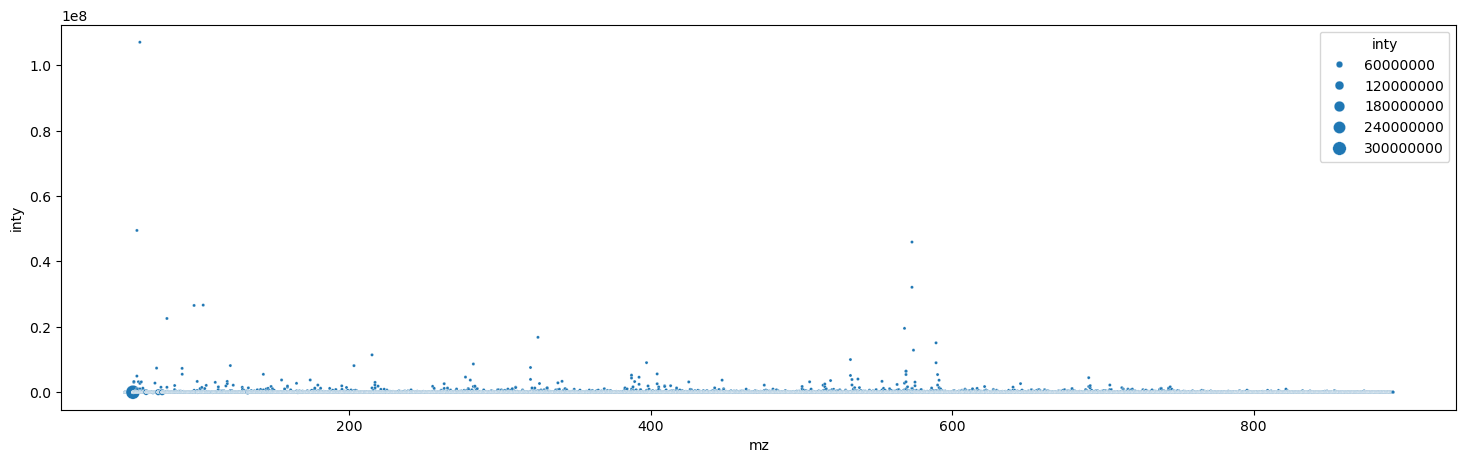

In [105]:
sns_plot(all_merged_df["mz"], all_merged_df["inty"], xlim=None, ylim=None, plottype="scatter",
         size=clustered_df["inty"], log=[], sizes=(5, 100))   # distinct: tab10, continous: hls

In [110]:
px.line(all_merged_df, "mz", "inty", log_y=True)